**Insert Important Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier


from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Explore the Dataset**

In [3]:
df = pd.read_csv('/content/drive/My Drive/dataset1.csv')
df.drop(['ProjectID'], 1, inplace=True)
df.head()

,RequirementText,class
0,The system shall refresh the display every 60 ...,PE
1,The application shall match the color of the s...,LF
2,If projected the data must be readable. On ...,US
3,The product shall be available during normal ...,A
4,If projected the data must be understandable...,US


**Group data by classes**

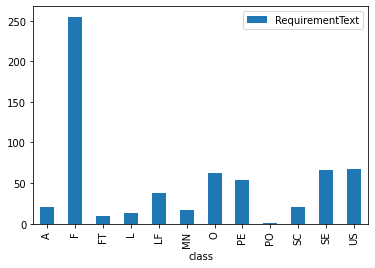

In [4]:
df.groupby('class').count().plot.bar(ylim=0)
plt.show()

**Clean Dataset**

In [5]:
nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")
df['cleaned'] = df['RequirementText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,RequirementText,class,cleaned
0,The system shall refresh the display every 60 ...,PE,the system shall refresh display everi second
1,The application shall match the color of the s...,LF,the applic shall match color schema set forth ...
2,If projected the data must be readable. On ...,US,if project data must readabl on x project scre...
3,The product shall be available during normal ...,A,the product shall avail normal busi hour as lo...
4,If projected the data must be understandable...,US,if project data must understand on x project s...


**Print Features shape**

In [6]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['cleaned']).toarray()
final_features.shape

(625, 734)

**Split Data and Train**

In [7]:
#split the dataset into training and testing set 
X = df['cleaned']
Y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

# instead of doing these steps one at a time, we can use a pipeline to complete then all at once
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k='all')),
                     ('clf', AdaBoostClassifier(n_estimators=30,
                         learning_rate=0.1))])

# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         4
           F       0.49      0.98      0.65        55
          FT       0.00      0.00      0.00         3
          LF       0.00      0.00      0.00        10
          MN       0.00      0.00      0.00         2
           O       0.67      0.33      0.44        12
          PE       1.00      0.09      0.17        11
          SC       0.00      0.00      0.00         5
          SE       0.00      0.00      0.00        14
          US       0.00      0.00      0.00         9

    accuracy                           0.47       125
   macro avg       0.22      0.14      0.13       125
weighted avg       0.37      0.47      0.34       125

[[ 0  4  0  0  0  0  0  0  0  0]
 [ 0 54  0  0  0  0  0  0  0  1]
 [ 0  2  0  0  0  1  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  4  0  0  0  0]
 [ 0  5  0  0  0  0  1  0  0  5]
 [ 0  3  0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


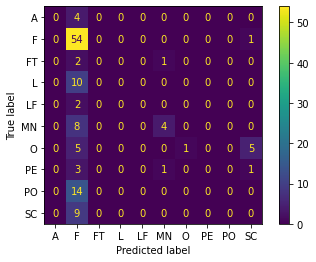

In [8]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_test, ytest)
plt.show()